In [26]:
import tensorflow as tf
import numpy as np
import pickle

### Encoding

In [27]:
# HTM SDR Scalar Encoder
# Input: Scalar
# Parameters: n - number of units, w - bits used to represent signal (width), b - buckets (i.e. resolution), 
#             min - minimum value of input (inclusive), max - maximum input value (inclusive)
class scalar_sdr:
    
    def __init__(self, b, w, min_, max_, shape=(1,1), neg=True):
        if type(b) != int or type(w) != int or type(min_) != float or type(max_) != float:
            raise TypeError("b - buckets must be int, w - width must be int, min_ must be float and max_ must be float")
        self.b = b # must be int
        self.w = w # must be int
        self.min = min_ # must be float
        self.max = max_ # must be float
        self.n = b+w-1 # number of units for encoding
        self.ndarray_shape = shape
        self.nodes = self.n*reduce(lambda x, y: x*y, self.ndarray_shape)
        self.neg = neg
        
    def encode(self,input_):
        if input_ > self.max or input_ < self.min:
            raise ValueError("Input outside encoder range!")
        if type(input_) != float:
            raise TypeError("Input must be float!")
        if self.neg:
            output = np.zeros(self.n)-1
        else:
            output = np.zeros(self.n)
        index = int((input_-self.min)/(self.max-self.min)*self.b)
        output[index:index+self.w] = 1
        return output
    
    def encode_ndarray(self,input_):
        if input_.shape != self.ndarray_shape:
            raise ValueError("Input dimensions do not match specified encoder dimensions!")
        output = []
        for i in np.nditer(input_, order='K'):
            output.append(self.encode(float(i)))
        return np.array(output)
    '''
    def decode(self,input_):
        if len(input_) != self.n: # or len(np.nonzero(input_+1)[0]) != self.w: <-- Can't have since the network is not guaranteed to produce this by any means!!!
            raise TypeError("Input does not correspond to encoder encoded data!")
        # output = np.nonzero(input_+1)[0][0]/float(self.b)*(self.max-self.min)+self.min <-- This doesn't work really since bits can randomly fire, taking the average is a more reasonable decoding
        median = np.median(np.nonzero(input_+1)[0])            
        try:
            output = int(median-float(self.w)/2.0)/float(self.b)*(self.max-self.min)+self.min # i.e. figure out center (median more outlier resistant than mean) and subtract width/2
        except ValueError:
            output = None
        return output
    '''
    def decode(self,input_):
        if len(input_) != self.n: 
            raise TypeError("Input length does not match encoder length!")
        if len(np.nonzero(input_+1)[0]) == 0:
            return np.nan
        max_ = 0
        output = 0.0
        for i in range(self.b):
            x = np.zeros(self.n)-1
            x[i:i+self.w] = 1
            if x.shape != input_.shape:
                input_ = input_.reshape(x.shape)
            score = np.inner(x,input_) # this was broken for some input formats 
            if score > max_:
                max_ = score
                output = float(i)/float(self.b)*(self.max-self.min)+self.min
        return output
            
    def decode_ndarray(self,input_):
        if input_.shape != (reduce(lambda x, y: x*y, self.ndarray_shape)*self.n,): 
            raise ValueError("Input dimensions do not match specified encoder dimensions!")
        input_ = input_.reshape(self.ndarray_shape+(self.n,))
        output = []
        for i in np.ndindex(self.ndarray_shape):
            output.append(self.decode(input_[i]))
        output = np.array(output).reshape(self.ndarray_shape)
        return output
    
    def set_ndarray_shape(self,shape):
        if type(shape) != tuple:
            raise TypeError("Must provide tuple of array dimensions!")
        self.ndarray_shape = shape

### Behavior data

In [28]:
fb = pickle.load(open("/home/roboy/dep/dep_data/bases/fb.pickle","rb"))
fs = pickle.load(open("/home/roboy/dep/dep_data/bases/fs.pickle","rb"))
sd = pickle.load(open("/home/roboy/dep/dep_data/bases/sd.pickle", "rb"))
zero = [np.zeros(fb[0].shape),np.zeros(fb[1].shape), np.zeros(fb[2].shape)]


bases = {"fb": fb, "fs": fs, "sd": sd, "zero": zero}

In [39]:
import matplotlib.pyplot as plt

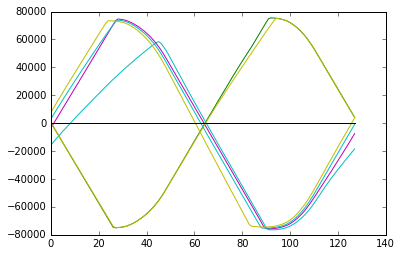

In [41]:
plt.figure(1)
plt.plot(fb[0])
plt.show()

In [29]:
behaviors = ["zero","fb","fs","sd"]
n = len(behaviors)
start = 0.0
width = 1.0/float(n)
brain_ranges = {}
for i in range(1,n+1):
    brain_ranges[behaviors[i-1]] = ((i-1)*width-start, i*width-start)
brain_id = {}
for behavior in behaviors:
    brain_id[behavior] = (brain_ranges[behavior][0]+brain_ranges[behavior][1])/2

### Hard coded neurons

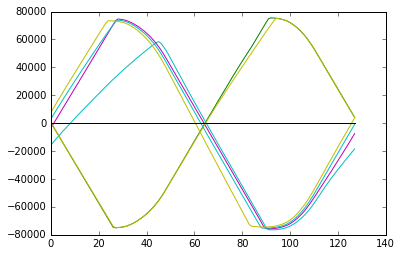

In [302]:
plt.figure(1)
plt.plot(bases["fb"][0])
plt.show()

In [342]:
active_motors = [1,3,4,5,10,12]
ts = [{},{}]
ts[0] = {'fb': 124, 'fs': 126, 'sd': 118, 'zero': 0}
ts[1] = {'fb': 62, 'fs': 63, 'sd': 59, 'zero': 0}

### Position only

In [343]:
pos_encoder = scalar_sdr(7,1,-100000.0,100000.0,shape=(6,1),neg=False)
behvs = {}
for id_ in bases:
    behvs[id_] = {}
    
for id_ in behvs:
    behvs[id_] = {}
    behvs[id_]["weights_pos"] = []
    for i in active_motors:
        m_pos = np.zeros((pos_encoder.n))
        for j in range(2):
            pos = pos_encoder.encode(float(bases[id_][0][ts[j][id_]][i]))
            m_pos += pos # hebbian learning of weights with only direct connections
        behvs[id_]["weights_pos"].append(m_pos)

behvs[id_]["weights_pos"] = np.array(behvs[id_]["weights_pos"]).reshape(1,6,pos_encoder.n,1)
behvs["pos_encoder"] = pos_encoder

In [344]:
pickle_out = open("neurons_pos.pickle","wb")
pickle.dump(behvs, pickle_out)
pickle_out.close()

In [311]:
'''
pos_encoder = scalar_sdr(7,1,-100000.0,100000.0,shape=(6,1),neg=False)

weights_pos = np.zeros((6,pos_encoder.n,1))

for i in range(len(active_motors)):
    for id_ in bases:
        # for each trigger position, create weights which will pass matching input through, and ignore others
        pos = bases[id_][0][ts[id_]][active_motors[i]]
        index_pos = int((pos-pos_encoder.min)/(pos_encoder.max-pos_encoder.min)*pos_encoder.b)
        weights_pos[i,index_pos:index_pos+pos_encoder.w] = 1
'''
id_ = 'fb'
index = ts[0][id_]
n = bases[id_][0].shape[0]

pos_ = []

for i in range(n):
    pos_.append(pos_encoder.encode_ndarray(bases[id_][0][i][active_motors].reshape(6,1)).reshape(6,pos_encoder.n))
pos_ = np.array(pos_)

temp = pos_.reshape(n,6,pos_encoder.n)
np.nonzero(temp[0])

#weights_pos = list(weights_pos.reshape(1,6,pos_encoder.n,1))
weights_pos = list(np.array(behvs[id_]["weights_pos"]).reshape(1,6,pos_encoder.n,1))
weights_pos = np.array(weights_pos*n)

with tf.name_scope("input"):
    pos_nodes = tf.placeholder(tf.float32, [None,6,pos_encoder.n], name="motor_pos")

with tf.name_scope("weights"):
    w_pos = tf.placeholder(tf.float32, [None,6,pos_encoder.n], name="pos_weights")

with tf.name_scope("trigger"):
    pos_input = tf.multiply(pos_nodes,w_pos)
    motor_activation = tf.nn.relu(tf.sign(pos_input))
    trigger_sum_0 = tf.reduce_sum(motor_activation, axis = 2)
    trigger_sum_1 = tf.reduce_sum(trigger_sum_0 - 0.99,axis=1)
    trigger_activation = tf.nn.relu(tf.sign(trigger_sum_1))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
out = sess.run(trigger_activation,{pos_nodes: pos_.reshape(n,6,pos_encoder.n), w_pos: weights_pos.reshape(n,6,pos_encoder.n), trigger_bias: trig_b, w_trig: trig_w})
#out = sess.run(trigger_activation,{pos_nodes: pos_.reshape(n,6,pos_encoder.n), vel_nodes: vel_.reshape(n,6,pos_encoder.n,vel_encoder.n), id_nodes: behv_.reshape(1,4), w_pos: weights_pos.reshape(n,6,pos_encoder.n), w_vel: weights_vel.reshape(n,6,pos_encoder.n,vel_encoder.n), w_id: weights_behv, trigger_bias: trig_b, w_trig: trig_w})
# Create a summary writer, add the 'graph' to the event file.
#writer = tf.summary.FileWriter("tf_logs", sess.graph)

'''
weights_pos_save = weights_pos[0].reshape(1,6,pos_encoder.n)
neurons_save = {"weights_pos": weights_pos_save, "pos_encoder": pos_encoder}

pickle_out = open("neurons_pos.pickle","wb")
pickle.dump(neurons_save, pickle_out)
pickle_out.close()
'''
''

''

In [312]:
out

array([ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.], dtype=float32)

### Position and velocity

In [13]:
pos_encoder = scalar_sdr(31,2,-100000.0,100000.0,shape=(6,1),neg=False)
vel_encoder = scalar_sdr(3,1,-70.0,70.0,shape=(6,1),neg=False)
#brain_encoder = scalar_sdr(4,1,0.,1.,neg=False)

weights_pos = np.zeros((6,pos_encoder.n,1))
weights_vel = np.ones((6,pos_encoder.n,vel_encoder.n))
#weights_behv = np.zeros((6,pos_encoder.n,vel_encoder.n,brain_encoder.n))-1

for i in range(len(active_motors)):
    for id_ in bases:
        # for each trigger position, create weights which will pass matching input through, and ignore others
        pos = bases[id_][0][ts[id_]][active_motors[i]]
        index_pos = int((pos-pos_encoder.min)/(pos_encoder.max-pos_encoder.min)*pos_encoder.b)
        weights_pos[i,index_pos:index_pos+pos_encoder.w] = 1
       
        # for each trigger position weight which passes a signal through, create weights for the velocity input such that 
        # the weights inhibit the position connection when the velocity does not match
        vel = bases[id_][1][ts[id_]][active_motors[i]]
        index_vel = int((vel-vel_encoder.min)/(vel_encoder.max-vel_encoder.min)*vel_encoder.b)
        weights_vel[i,index_pos:index_pos+pos_encoder.w,index_vel:index_vel+vel_encoder.w] = 0
        
        # for each velocity connection, inhibit velocity connections that do not match the current states brain id
        #brain = id_to_int[id_]
        #weights_behv[i,index_pos,index_vel,brain] = 0

In [14]:
id_ = 'fb'
index = ts[id_]
n = bases[id_][0].shape[0]

pos_ = []
vel_ = []

for i in range(n):
    pos_.append(pos_encoder.encode_ndarray(bases[id_][0][i][active_motors].reshape(6,1)).reshape(6,pos_encoder.n))
    vel_.append(vel_encoder.encode_ndarray(bases[id_][1][i][active_motors].reshape(6,1)).reshape(6,vel_encoder.n))
pos_ = np.array(pos_)
vel_ = np.array(vel_)

trig_b = np.ones((n,6))
trig_w = np.zeros((n,6))-0.99999

a = np.zeros((n,6,pos_encoder.n,vel_encoder.n))
for k in range(n):
    for i in range(6):
        for j in range(pos_encoder.n):
            a[k][i][j] = vel_[k][i].reshape(vel_encoder.n)
            
vel_ = a

In [15]:
weights_pos = list(weights_pos.reshape(1,6,pos_encoder.n,1))
weights_pos = np.array(weights_pos*n)

weights_vel = list(weights_vel.reshape(1,6,pos_encoder.n,vel_encoder.n))
weights_vel = np.array(weights_vel*n)

In [16]:
with tf.name_scope("input"):
    pos_nodes = tf.placeholder(tf.float32, [None,6,pos_encoder.n], name="motor_pos")
    vel_nodes = tf.placeholder(tf.float32, [None,6,pos_encoder.n,vel_encoder.n], name="motor_vel")
    trigger_bias = tf.placeholder(tf.float32, [None,6], name = "trigger_bias")

with tf.name_scope("weights"):
    w_pos = tf.placeholder(tf.float32, [None,6,pos_encoder.n], name="pos_weights")
    w_vel = tf.placeholder(tf.float32, [None,6,pos_encoder.n,vel_encoder.n], name="vel_weights")
    w_trig = tf.placeholder(tf.float32, [None,6], name = "trigger_weights")

with tf.name_scope("trigger"):
    vel_input = tf.multiply(w_vel,vel_nodes)
    vel_inhibitor = tf.reduce_sum(tf.nn.relu(tf.sign(vel_input)),axis=3)
    pos_input = tf.multiply(pos_nodes,w_pos)
    motor_sum = pos_input + vel_inhibitor*-1
    motor_activation = tf.nn.relu(tf.sign(motor_sum))
    trigger_sum_0 = tf.reduce_sum(motor_activation, axis = 2)
    bias = tf.multiply(trigger_bias,w_trig)
    trigger_sum_1 = tf.reduce_sum(trigger_sum_0 + bias,axis=1)
    trigger_activation = tf.nn.relu(tf.sign(trigger_sum_1))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print pos_.reshape(n,6,pos_encoder.n).shape, vel_.reshape(n,6,pos_encoder.n,vel_encoder.n).shape, weights_pos.reshape(n,6,pos_encoder.n).shape, weights_vel.reshape(n,6,pos_encoder.n,vel_encoder.n).shape, trig_b.shape,trig_w.shape
out = sess.run(trigger_activation,{pos_nodes: pos_.reshape(n,6,pos_encoder.n), vel_nodes: vel_.reshape(n,6,pos_encoder.n,vel_encoder.n), w_pos: weights_pos.reshape(n,6,pos_encoder.n), w_vel: weights_vel.reshape(n,6,pos_encoder.n,vel_encoder.n), trigger_bias: trig_b, w_trig: trig_w})
#out = sess.run(trigger_activation,{pos_nodes: pos_.reshape(n,6,pos_encoder.n), vel_nodes: vel_.reshape(n,6,pos_encoder.n,vel_encoder.n), id_nodes: behv_.reshape(1,4), w_pos: weights_pos.reshape(n,6,pos_encoder.n), w_vel: weights_vel.reshape(n,6,pos_encoder.n,vel_encoder.n), w_id: weights_behv, trigger_bias: trig_b, w_trig: trig_w})
# Create a summary writer, add the 'graph' to the event file.
writer = tf.summary.FileWriter("tf_logs", sess.graph)

(128, 6, 32) (128, 6, 32, 3) (128, 6, 32) (128, 6, 32, 3) (128, 6) (128, 6)


In [33]:
'''
weights_pos_save = weights_pos[0].reshape(1,6,pos_encoder.n)
weights_vel_save = weights_vel[0].reshape(1,6,pos_encoder.n,vel_encoder.n)
trig_b_save = trig_b[0].reshape(1,6)
trig_w_save = trig_w[0].reshape(1,6)
neurons_save = {"weights_pos": weights_pos_save, "weights_vel": weights_vel_save, "trig_b": trig_b_save, "trig_w": trig_w_save}
'''
''

''

In [34]:
'''
pickle_out = open("neurons.pickle","wb")
pickle.dump(neurons_save, pickle_out)
pickle_out.close()
'''
''

''

In [17]:
out

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.], dtype=float32)

### Brain id to pos/vel network selection w/ LAM

In [167]:
class LAM:
    def __init__(self,shape,weights=None):
        self.shape = shape
        try:
            if weights == None:
                self.weights = np.zeros(shape)
        except ValueError:
            self.weights = weights
    
    def store(self,input,output):
        dW = np.outer(input,output)
        self.weights += dW
        
    def recall(self,input,threshold=0,print_=False):
        output = input.dot(self.weights)-threshold
        if print_ == True:
            print output
        output[output > 0] = 1
        output[output < 0] = 0
        return output

    def save_weights(self,filename):
        np.save(filename, self.weights)
        
    def load_weights(self,filename):
        weights = np.load(filename)
        if weights.shape == self.shape:
            self.weights = weights
        else:
            raise ValueError("Dimensions of specified weight array does not match network weight dimensions!")

In [89]:
brain_encoder = scalar_sdr(4,1,0.,1.,neg=False)
inputs = np.array([brain_encoder.encode(val) for val in brain_id.values()])
outputs = np.array([[pos_encoder.n*[i] for i in input_] for input_ in inputs])
lam = LAM((inputs[0].shape[0],outputs[0].flatten().shape[0]))
for i in range(len(inputs)):
    lam.store(inputs[i],outputs[i].flatten())

In [100]:
lam.recall(brain_encoder.encode(brain_id["fb"]))-1

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.])

In [ ]:
# i.e. each chunk corresponds to position being fed to a particular network, and just sum it up with the position being
# fed to cancel out the signal to that network

### Fix with nice matrix multiplication

In [8]:
behvs = {}
for id_ in bases:
    behvs[id_] = {}
id_to_d = {"fb": 0, "fs": 0, "sd": 0, "zero": 0}

In [9]:
# Generate weights

# use this to , these weights need to be loaded into the trigger_callback module in the dep_memory node
# and currently this is done manually so be sure to specify the correct directories etc.

# need to use width = 1 for pos encoder using the encoding as input and output for training position weights with 
# hebbian learning
pos_encoder = scalar_sdr(41,3,-100000.0,100000.0,shape=(6,1),neg=False)
vel_encoder = scalar_sdr(3,1,-70.0,70.0,shape=(6,1),neg=False)

for id_ in behvs:
    d = id_to_d[id_]
    behvs[id_] = {}
    behvs[id_]["weights_pos"] = []
    behvs[id_]["weights_vel"] = []
    for i in active_motors:
        pos = pos_encoder.encode(float(bases[id_][0][ts[id_]-d][i]))
        m_pos = pos # hebbian learning of weights with only direct connections
        behvs[id_]["weights_pos"].append(m_pos)
        
        vel = vel_encoder.encode(float(bases[id_][1][ts[id_]-d][i]))
        m_vel = np.outer(pos,vel) # hebbian learning of weights
        behvs[id_]["weights_vel"].append(m_vel)

behvs[id_]["weights_pos"] = np.array(behvs[id_]["weights_pos"]).reshape(1,6,pos_encoder.n,1)
behvs[id_]["weights_vel"] = np.array(behvs[id_]["weights_vel"]).reshape(1,6,pos_encoder.n,vel_encoder.n)
behvs["pos_encoder"] = pos_encoder
behvs["vel_encoder"] = vel_encoder

In [10]:
'''
neurons_save = behvs
pickle_out = open("neurons_individual_behvs.pickle","wb")
pickle.dump(neurons_save, pickle_out)
pickle_out.close()
'''

'\nneurons_save = behvs\npickle_out = open("neurons_individual_behvs.pickle","wb")\npickle.dump(neurons_save, pickle_out)\npickle_out.close()\n'

In [19]:
# Generate data

# by varying "id_" you can inspect the output triggering output the network will generate for each state of the behavior
# stored in a recording of the behavior in bases

id_ = 'fb'
n = bases[id_][0].shape[0]

pos_ = []
vel_ = []

for i in range(n):
    pos_.append(pos_encoder.encode_ndarray(bases[id_][0][i][active_motors].reshape(6,1)).reshape(6,pos_encoder.n,1))
    vel_.append(vel_encoder.encode_ndarray(bases[id_][1][i][active_motors].reshape(6,1)).reshape(6,vel_encoder.n,1))
pos_ = np.array(pos_)
vel_ = np.array(vel_)

# need to have weights for each test
weights_pos = np.array(list(behvs[id_]["weights_pos"])*n).reshape(n,6,pos_encoder.n,1)
weights_vel = np.array(list(behvs[id_]["weights_vel"])*n).reshape(n,6,pos_encoder.n,vel_encoder.n)


with tf.name_scope("input"):
    pos_nodes = tf.placeholder(tf.float32, [None,6,pos_encoder.n,1], name="motor_pos")
    vel_nodes = tf.placeholder(tf.float32, [None,6,vel_encoder.n,1], name="motor_vel")

with tf.name_scope("weights"):
    w_pos = tf.placeholder(tf.float32, [None,6,pos_encoder.n,1], name="pos_weights")
    w_vel = tf.placeholder(tf.float32, [None,6,pos_encoder.n,vel_encoder.n], name="vel_weights")

with tf.name_scope("trigger"):
    vel_input = tf.matmul(w_vel,vel_nodes)
    vel_inhibitor = tf.nn.relu(tf.sign(vel_input))
    pos_input = w_pos*pos_nodes
    motor_sum = pos_input + (vel_inhibitor - 1)
    motor_activation = tf.nn.relu(tf.sign(motor_sum))
    trigger_sum_0 = tf.reduce_sum(motor_activation, axis = 2) 
    trigger_sum_1 = tf.reduce_sum(trigger_sum_0 - 0.99, axis = 1)
    trigger_activation = tf.nn.relu(tf.sign(trigger_sum_1))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
out = sess.run(trigger_activation,{pos_nodes: pos_, vel_nodes: vel_, w_pos: weights_pos, w_vel: weights_vel})
sess.close()

# Create a summary writer, add the 'graph' to the event file.
# writer = tf.summary.FileWriter("tf_logs", sess.graph)
# This graph can be inspected with tensorboard: tensorboard --logdir="tf_logs"

In [20]:
out.reshape(1,n)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)

### The idea

In [382]:
# this is it, but it doesn't make sense in terms of neuron connections
a = weights_behv[0]+1
b = np.inner(a,behv_[0])
c = []
for i in range(6):
    x = b[i].dot(vel_[ts[id_]][i])
    c.append(x)
c = np.array(c)
d = np.sum(c*pos_[ts[id_]],axis=1)
d

NameError: name 'weights_behv' is not defined